In [32]:
import pandas as pd
import numpy as np
data_rfe=pd.read_csv('norm_guizhou.csv')
data_rfe=np.array(data_rfe)
fea=data_rfe[:,:49]
target=data_rfe[:,49]
x_test=fea[:170,:]
y_test=target[:170]
x_train=fea[170:,:]
y_train=target[170:]

# SVM-RFE_RELIEF

In [33]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_relief_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,alpha,folds):
        #kf=KFold(n_splits=folds,shuffle=False)
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,x_train,y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,x_train,y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            #print(relief_score)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
    def sele_feature(self,alpha,optim_featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        i=featu_num
        while True:
            if len(candi_fea)==optim_featur_num:
                return candi_fea
            relief_score=(reliefF.reliefF(self.X_train[:,candi_fea],self.Y_train)).reshape(1,i)
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                #print(len(candi_fea_copy))
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            total_score=alpha*relief_score+(1-alpha)*np.array(rfe_score)
            #print(total_score)
            index_=np.argmin(total_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(i)
            i-=1

In [34]:
rfe_relief_model=rfe_relief_SVM(x_train,y_train,2,0.1)

In [35]:
aver_mean_lis1,F_measure_lis1=rfe_relief_model.featu_score(0.15,5)
print(aver_mean_lis1,F_measure_lis1)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7902173913043479, 0.7937940393548724, 0.7876611514170885, 0.7718239469700924, 0.7570267237329714, 0.7539694138524975, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.7873

In [36]:
aver_mean_lis2,F_measure_lis2=rfe_relief_model.featu_score(0.25,5)
print(aver_mean_lis2,F_measure_lis2)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7902173913043479, 0.7937940393548724, 0.7876611514170885, 0.7718239469700924, 0.7570267237329714, 0.7539694138524975, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.7873

In [37]:
aver_mean_lis3,F_measure_lis3=rfe_relief_model.featu_score(0.35,5)
print(aver_mean_lis3,F_measure_lis3)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7902173913043479, 0.7937940393548724, 0.7876611514170885, 0.7718239469700924, 0.7570267237329714, 0.7539694138524975, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.7873

In [38]:
aver_mean_lis4,F_measure_lis4=rfe_relief_model.featu_score(0.45,5)
print(aver_mean_lis4,F_measure_lis4)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7902173913043479, 0.7937940393548724, 0.7876611514170885, 0.7718239469700924, 0.7733636933034084, 0.7539694138524975, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.7873

In [39]:
aver_mean_lis5,F_measure_lis5=rfe_relief_model.featu_score(0.55,5)
print(aver_mean_lis5,F_measure_lis5)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7948131426483636, 0.7886828644501278, 0.7764340518816222, 0.7784787828174748, 0.776949475442351, 0.7575512813821181, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.78733

In [40]:
aver_mean_lis6,F_measure_lis6=rfe_relief_model.featu_score(0.65,5)
print(aver_mean_lis6,F_measure_lis6)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7948131426483636, 0.7886828644501278, 0.7764340518816222, 0.7784787828174748, 0.776949475442351, 0.7575512813821181, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.78733

In [41]:
aver_mean_lis7,F_measure_lis7=rfe_relief_model.featu_score(0.75,5)
print(aver_mean_lis7,F_measure_lis7)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7948131426483636, 0.7886828644501278, 0.7764340518816222, 0.7784787828174748, 0.776949475442351, 0.7575512813821181, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.78733

In [42]:
aver_mean_lis8,F_measure_lis8=rfe_relief_model.featu_score(0.85,5)
print(aver_mean_lis8,F_measure_lis8)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7907302051255285, 0.791243018946709, 0.7948131426483636, 0.7886828644501278, 0.7764340518816222, 0.7784787828174748, 0.776949475442351, 0.7575512813821181, 0.7544874471527742, 0.7524388016075996, 0.748873897385041, 0.7447896549924318, 0.7376415783704786, 0.7376428832402526, 0.7361174904744507, 0.7350814238738974, 0.7396771752179132, 0.7330445221566888, 0.7315139099117908, 0.7294691789759382, 0.7264105642256903, 0.7264092593559163, 0.725388851192651, 0.723860848687301, 0.7192637924735112, 0.7110926979487446, 0.7054804530507855, 0.704971553838927, 0.7013988203977244, 0.6932342502218278, 0.6896615167806253, 0.6860887833394227, 0.6840427475337962, 0.6794522156688763, 0.6712850357534318, 0.6763896863093064, 0.6723093585260191, 0.6677175217913253, 0.6631243801868574, 0.6646445534735633, 0.6626011274074847, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.78733

In [43]:
aver_mean_lis9,F_measure_lis9=rfe_relief_model.featu_score(0.95,5)
print(aver_mean_lis9,F_measure_lis9)

[0.78103371783496, 0.7886893887989979, 0.7881765749778171, 0.7922647319797484, 0.7922608173704264, 0.7937979539641944, 0.7917532230283417, 0.7907341197348504, 0.7963554987212277, 0.7963581084607756, 0.7876755049846025, 0.7789876820293336, 0.7805209040137795, 0.7805169894044575, 0.7764405762304921, 0.7738856412130068, 0.7652095620857039, 0.7682773109243698, 0.7677658019729631, 0.7432355550916019, 0.7447674722062738, 0.7447726916853699, 0.7411986533743932, 0.7447805209040137, 0.7391643613967326, 0.7376350540216086, 0.7350827287436714, 0.7274166188214417, 0.7233349861683804, 0.7161895192859753, 0.7218004593141606, 0.7207813560206692, 0.7095516467456549, 0.7085338483219374, 0.7044548254084243, 0.7064956417349548, 0.6993449553734538, 0.6952672373297146, 0.691695808758286, 0.6891434834803487, 0.685570750039146, 0.6814917271256329, 0.6794496059293282, 0.6743397358943579, 0.6687222715173026, 0.6580053760634689, 0.6549415418341249, 0.6549415418341249, 0.6544326426222662] [0.779501638224168, 0.7

In [61]:
np.max(aver_mean_lis1[:9]),np.max(aver_mean_lis2[:9]),np.max(aver_mean_lis3[:9]),np.max(aver_mean_lis4[:9]),np.max(aver_mean_lis5[:9])

(0.7937940393548724,
 0.7937940393548724,
 0.7937940393548724,
 0.7937940393548724,
 0.7948131426483636)

In [62]:
np.max(aver_mean_lis6[:9]),np.max(aver_mean_lis7[:9]),np.max(aver_mean_lis8[:9]),np.max(aver_mean_lis9[:9])

(0.7948131426483636,
 0.7948131426483636,
 0.7948131426483636,
 0.7963554987212277)

In [63]:
np.argmax(aver_mean_lis9[:9])

8

# SVM-RFE

In [45]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class rfe_SVM:
    def __init__(self,x_train,y_train,c,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=c
        self.Gamma=gamma
    def featu_score(self,folds):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[j for j in range(featu_num)]
        i=featu_num
        aver_lis=[j for j in range(featu_num)]
        F_lis=[j for j in range(featu_num)]
        aver=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
        aver_lis[i-1]=aver
        F1=mean(cross_val_score(estimator,self.X_train,self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
        F_lis[i-1]=F1
        while True:
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                rfe_score[k]=scor_fea
                k=k+1     
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            i-=1
            aver=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="accuracy",cv=folds,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:,candi_fea],self.Y_train,scoring="f1",cv=folds,n_jobs=-1))
            aver_lis[i-1]=aver
            F_lis[i-1]=F1
            if i==1:
                break
        return aver_lis,F_lis
   
    def featu_subset(self,featur_num):
        estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
        rank_=[]
        featu_num=self.X_train.shape[1]
        candi_fea=[i for i in range(featu_num)]
        while True:
            if len(candi_fea)==featur_num:
                return candi_fea
            estimator.fit(self.X_train[:,candi_fea],self.Y_train)
            suppor_index=estimator.support_
            support_num=len(suppor_index)
            support_vector=estimator.support_vectors_
            dual_coef=estimator.dual_coef_[0]
            rfe_score=[i for i in range(len(candi_fea))]
            z=np.exp(-self.Gamma*np.sum(support_vector*support_vector,axis=1))
            matrix_z=np.outer(z, z)
            y_matrix=np.outer(self.Y_train[suppor_index],self.Y_train[suppor_index])
            H_matrix=np.exp(2*self.Gamma*support_vector@support_vector.T)*matrix_z*y_matrix
            orig_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix),dual_coef*self.Y_train[suppor_index])
            k=0
            for fea in candi_fea:
                copy_support_vector=self.X_train[suppor_index,:]
                candi_fea_copy=candi_fea.copy()
                candi_fea_copy.remove(fea)
                removed_support_vector=copy_support_vector[:,candi_fea_copy]
                z1=np.exp(-self.Gamma*np.sum(removed_support_vector*removed_support_vector,axis=1))
                matrix_z1=np.outer(z1, z1)
                H_matrix1=np.exp(2*self.Gamma*removed_support_vector@removed_support_vector.T)*matrix_z1*y_matrix
                after_loss=np.dot(np.dot(dual_coef*self.Y_train[suppor_index],H_matrix1),dual_coef*self.Y_train[suppor_index])
                scor_fea=np.abs(orig_loss-after_loss)/2
                #print(scor_fea)
                rfe_score[k]=scor_fea
                k=k+1     
            #print(rfe_score)
            index_=np.argmin(rfe_score)
            remove_fea=candi_fea[index_]
            candi_fea.remove(remove_fea)
            print(1)

In [46]:
rfe_SVM_model=rfe_SVM(x_train,y_train,2,0.1)
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis=rfe_SVM_model.featu_score(5)

In [47]:
rfe_SVM_aver_mean_lis,rfe_SVM_F_measure_lis

([0.78103371783496,
  0.7886893887989979,
  0.7881765749778171,
  0.7922647319797484,
  0.7907302051255285,
  0.791243018946709,
  0.7902173913043479,
  0.7937940393548724,
  0.7876611514170885,
  0.7718239469700924,
  0.7570267237329714,
  0.7539694138524975,
  0.7544874471527742,
  0.7524388016075996,
  0.748873897385041,
  0.7447896549924318,
  0.7376415783704786,
  0.7376428832402526,
  0.7361174904744507,
  0.7350814238738974,
  0.7396771752179132,
  0.7330445221566888,
  0.7315139099117908,
  0.7294691789759382,
  0.7264105642256903,
  0.7264092593559163,
  0.725388851192651,
  0.723860848687301,
  0.7192637924735112,
  0.7110926979487446,
  0.7054804530507855,
  0.704971553838927,
  0.7013988203977244,
  0.6932342502218278,
  0.6896615167806253,
  0.6860887833394227,
  0.6840427475337962,
  0.6794522156688763,
  0.6712850357534318,
  0.6763896863093064,
  0.6723093585260191,
  0.6677175217913253,
  0.6631243801868574,
  0.6646445534735633,
  0.6626011274074847,
  0.6580053760634

# SVM-RELIEF

In [48]:
from skfeature.function.similarity_based import reliefF
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from numpy import mean 
from sklearn.model_selection import cross_val_score
class relief_SVM:
    def __init__(self,x_train,y_train,C,gamma):
        self.X_train=x_train
        self.Y_train=y_train
        self.C=C
        self.Gamma=gamma
    def featu_score(self,folds):
        kf=KFold(n_splits=folds,shuffle=False)
        featu_num=self.X_train.shape[1]
        relief_fea_score=reliefF.reliefF(self.X_train,self.Y_train)
        relief_candi_fea=list(reliefF.feature_ranking(relief_fea_score))
        aver_lis=[i for i in range(featu_num)]
        F_lis=[i for i in range(featu_num)]
        for i in range(featu_num):
            estimator=SVC(C=self.C, kernel='rbf',gamma=self.Gamma)
            candi_fea=relief_candi_fea[:(i+1)]
            aver=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="accuracy",cv=kf,n_jobs=-1))
            F1=mean(cross_val_score(estimator,self.X_train[:, candi_fea],self.Y_train,scoring="f1",cv=kf,n_jobs=-1))
            aver_lis[i]=aver
            F_lis[i]=F1 
        return aver_lis,F_lis

In [49]:
relief_SVM_model=relief_SVM(x_train,y_train,2,0.1)
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis=relief_SVM_model.featu_score(5)

In [50]:
relief_SVM_aver_mean_lis,relief_SVM_F_measure_lis

([0.7810298032256381,
  0.7800080901925988,
  0.7902213059136698,
  0.7876742001148286,
  0.791243018946709,
  0.7876676757659585,
  0.7866459627329193,
  0.785620335090558,
  0.7805169894044575,
  0.7845986220575187,
  0.7830706195521687,
  0.784088417975886,
  0.7866446578631452,
  0.7861331489117387,
  0.7830758390312648,
  0.7815400073072707,
  0.781031108095412,
  0.7784644292499608,
  0.7789641943734015,
  0.7820241139934235,
  0.781516519651339,
  0.7774179236912155,
  0.7707787462811211,
  0.7692481340362233,
  0.7794717887154862,
  0.7820371626911634,
  0.7815269586095307,
  0.7769364267446109,
  0.7774453259564695,
  0.7754110339788088,
  0.7759160185813456,
  0.7743854063364476,
  0.7733623884336345,
  0.7733584738243124,
  0.772339370530821,
  0.7672321102353986,
  0.7616159507281173,
  0.7580366929380448,
  0.7611018320371628,
  0.7565034709535988,
  0.757523879116864,
  0.7616042069001514,
  0.7503666684064931,
  0.7524127042121196,
  0.7529255180333003,
  0.7462863406232

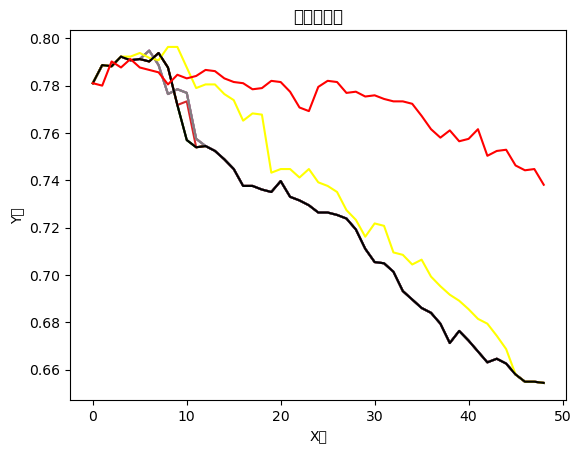

In [31]:
import matplotlib.pyplot as plt

fea_num=[i for i in range(49)]

# 创建图形
plt.plot(fea_num, aver_mean_lis1)
plt.plot(fea_num, aver_mean_lis2)
plt.plot(fea_num, aver_mean_lis3)
plt.plot(fea_num, aver_mean_lis4)
plt.plot(fea_num, aver_mean_lis5)
plt.plot(fea_num, aver_mean_lis6)
plt.plot(fea_num, aver_mean_lis7)
plt.plot(fea_num, aver_mean_lis8)
plt.plot(fea_num, aver_mean_lis9,color="yellow")
plt.plot(fea_num, rfe_SVM_aver_mean_lis,color="black")
plt.plot(fea_num, relief_SVM_aver_mean_lis,color="red")



# 添加标题和标签
plt.title('简单折线图')
plt.xlabel('X轴')
plt.ylabel('Y轴')

# 显示图形
plt.show()


In [54]:
guizhou_accuracy=[]
guizhou_accuracy.append(aver_mean_lis1)
guizhou_accuracy.append(aver_mean_lis2)
guizhou_accuracy.append(aver_mean_lis3)
guizhou_accuracy.append(aver_mean_lis4)
guizhou_accuracy.append(aver_mean_lis5)
guizhou_accuracy.append(aver_mean_lis6)
guizhou_accuracy.append(aver_mean_lis7)
guizhou_accuracy.append(aver_mean_lis8)
guizhou_accuracy.append(aver_mean_lis9)
guizhou_accuracy.append(rfe_SVM_aver_mean_lis)
guizhou_accuracy.append(relief_SVM_aver_mean_lis)

In [55]:
colu=[i for i in range(1,50)]
guizhou_acurracy_dataframe=pd.DataFrame(columns=colu,data=np.array(guizhou_accuracy))
guizhou_acurracy_dataframe.to_csv("guizhou_accuracy.csv")

In [56]:
guizhou_F_measure=[]
guizhou_F_measure.append(F_measure_lis1)
guizhou_F_measure.append(F_measure_lis2)
guizhou_F_measure.append(F_measure_lis3)
guizhou_F_measure.append(F_measure_lis4)
guizhou_F_measure.append(F_measure_lis5)
guizhou_F_measure.append(F_measure_lis6)
guizhou_F_measure.append(F_measure_lis7)
guizhou_F_measure.append(F_measure_lis8)
guizhou_F_measure.append(F_measure_lis9)
guizhou_F_measure.append(rfe_SVM_F_measure_lis)
guizhou_F_measure.append(relief_SVM_F_measure_lis)

In [57]:
colu=[i for i in range(1,50)]
guizhou_F_measure_dataframe=pd.DataFrame(columns=colu,data=np.array(guizhou_F_measure))
guizhou_F_measure_dataframe.to_csv("guizhou_F_measure.csv")